# Notebook 1 — Approximating a function with a sum of tanh “steps”

This notebook demonstrates a classic *function approximation* idea: represent a complicated target function $g(x)$ as a weighted sum of simple nonlinear “building blocks”:

$$\hat g(x) = \sum_{i=1}^N \alpha_i\,\sigma(w_i x + b_i)$$

Here we will use $\sigma(\cdot)=\tanh(\cdot)$.

We **fix** the output weights $\alpha_i$ randomly (to keep things simple) and **optimize** the inner weights $w_i$ and biases $b_i$ by minimizing mean squared error (MSE).

We then compare different values of $N$ (number of hidden units) to see how approximation quality changes.

> Notes for students:
>
> * $w_i$ controls the *steepness* / horizontal scaling of each tanh.
> * $b_i$ controls the *shift* (where the transition happens).
> * Increasing $N$ usually increases expressiveness, but optimization can become harder.


In [1]:
# (Colab) Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Make plots a bit larger in Colab
plt.rcParams["figure.figsize"] = (10, 6)


## 1. Define the target function
This is the function we want to approximate on the interval $[-2,2]$.

$$g(x) = \sin(\pi x)\,x^2 - \frac{1}{2+\cos(x)}$$


In [2]:
def target_function(x):
    """Target function g(x) we want to approximate."""
    return np.sin(np.pi * x) * x**2 - 1.0 / (2.0 + np.cos(x))


## 2. Choose the nonlinearity $\sigma$
We'll use $\tanh$.

Try switching to sigmoid or a step function to see how it changes behavior (but note: the step function is not smooth, so optimization can be harder).


In [3]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigma(x):
    # Smooth nonlinearity: good for gradient-based optimization
    return np.tanh(x)

    # Alternatives (uncomment to experiment):
    # return sigmoid(x)
    # return np.heaviside(x, 0.5)


## 3. Define the model: sum of nonlinear “steps”
This is basically a 1-hidden-layer neural network with activation $\sigma$.


In [6]:
def step_approximation(x, N, alpha, w, b):
    """Compute g'(x) = sum_i alpha_i * sigma(w_i * x + b_i)."""
    y = np.zeros_like(x, dtype=float)
    for i in range(N):
        y += alpha[i] * sigma(w[i] * x + b[i])
    return y


## 4. Define the loss (MSE) and pack/unpack parameters
We optimize over a single vector `params` that contains all $w$'s followed by all $b$'s.

*Input:* `params = [w_1,...,w_N, b_1,...,b_N]`

*Output:* scalar MSE.


In [7]:
def loss_function(params, x, y, N, alpha):
    """Mean squared error between target y and prediction y_pred."""
    w = params[:N]
    b = params[N:]
    y_pred = step_approximation(x, N, alpha, w, b)
    return np.mean((y - y_pred) ** 2)


## 5. Generate training data
We'll sample 200 points evenly in $[-2,2]$.


In [8]:
np.random.seed(0)

x_train = np.linspace(-2, 2, 200)
y_train = target_function(x_train)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)


x_train shape: (200,)
y_train shape: (200,)


## 6. Fit models with different numbers of units $N$
We will:
1. Randomly choose $\alpha_i$ (fixed).
2. Initialize $w_i$ and $b_i$ randomly.
3. Use `scipy.optimize.minimize` with L-BFGS-B to optimize $w,b$.

### Why L-BFGS-B?
- It's a quasi-Newton method: often converges faster than plain gradient descent for small/medium problems.
- Handles many parameters efficiently.

### Exercise ideas
- Also optimize $\alpha$ (not fixed).
- Compare L-BFGS-B vs Powell.
- Try different activations (sigmoid, ReLU-like approximations).


Training with N = 1
Training with N = 2
Training with N = 3
Training with N = 4
Training with N = 5
Training with N = 6
Training with N = 7
Training with N = 8
Training with N = 9
Training with N = 10


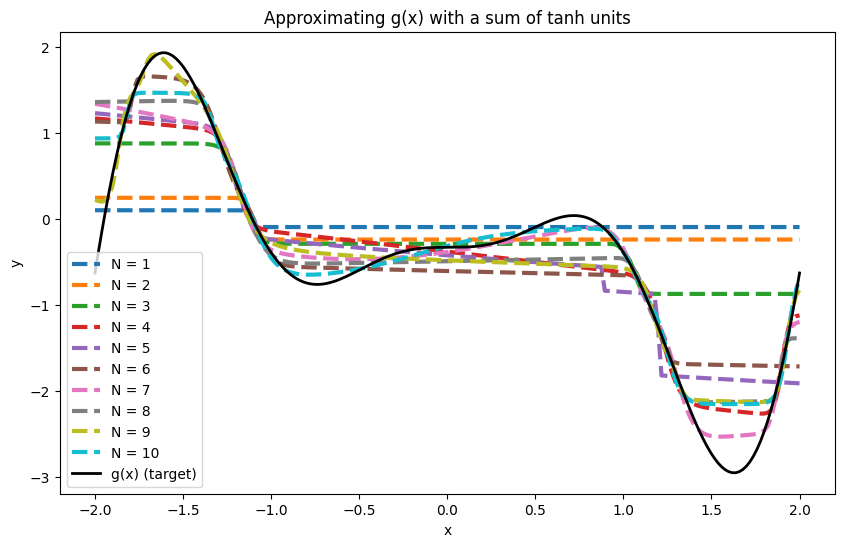

In [9]:
fig, ax = plt.subplots(1, 1)

Ns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for N in Ns:
    print(f"Training with N = {N}")

    # alpha is FIXED random (we are NOT optimizing it in this demo)
    alpha = np.random.uniform(-1, 1, N)

    # Initialize w and b
    w_init = np.random.uniform(-1, 1, N)
    b_init = np.random.uniform(-1, 1, N)

    # Combine into a single parameter vector for the optimizer
    initial_params = np.concatenate([w_init, b_init])

    # Optimize w and b to minimize MSE
    result = minimize(
        loss_function,
        initial_params,
        args=(x_train, y_train, N, alpha),
        method="L-BFGS-B",
        options={"maxiter": 1000}
    )

    # Unpack optimized params
    w_opt = result.x[:N]
    b_opt = result.x[N:]

    # Predict on training grid
    y_hat = step_approximation(x_train, N, alpha, w_opt, b_opt)

    # Plot approximation for this N
    ax.plot(x_train, y_hat, ls="--", lw=3, label=f"N = {N}")

# Plot the true function
ax.plot(x_train, y_train, color="black", lw=2, label="g(x) (target)")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Approximating g(x) with a sum of tanh units")
ax.legend()
plt.show()


## 7. Discussion
- For small $N$, the model may be too rigid.
- As $N$ increases, the approximation can improve.
- But optimization can also become trickier (more parameters, more local minima).

Try rerunning with a different random seed, or using a different activation in `sigma()`.
